In [158]:
import copy
from abc import ABC, abstractmethod
from time import time

from matplotlib import pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ortho_group
from torch import exp, tanh, abs, log

# Layer Setup

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

torch.set_default_device(device)
torch.set_default_dtype(torch.double)

Device: cpu


In [25]:
class FFNN(nn.Module):
    def __init__(self, in_size: int, layer_sizes: list[int], out_size: int) -> None:
        super().__init__()

        sizes = [in_size] + list(layer_sizes) + [out_size]
        layers = [nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]

        # splice in ReLU layers
        for i in range(len(layers) - 1):
            layers.insert(i * 2 + 1, nn.ReLU())

        self.layers = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor):
        return self.layers(X)

In [26]:
class Layer(nn.Module, ABC):
    # TODO: later abc __init__

    @abstractmethod
    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        pass

    @abstractmethod
    def backward(self, Z: torch.Tensor):
        pass

In [27]:
class OrthonormalLayer(Layer):
    def __init__(self, size: int):
        super().__init__()

        self.o = torch.tensor(ortho_group.rvs(size))

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            return X @ self.o, 0
        else:
            return X @ self.o

    def backward(self, Z: torch.Tensor):
        return Z @ self.o.T

In [28]:
class BijectiveLayer(Layer):
    def __init__(self, size: int, hidden_sizes: list[int]) -> None:
        super().__init__()

        assert size > 1, "Layer size must be at least 2!"

        self.skip_size = size // 2
        self.non_skip_size = size - self.skip_size
        self.ffnn = FFNN(self.skip_size, hidden_sizes, self.non_skip_size + 1)  # returns t & s

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        skip_connection = X[:, :self.skip_size]
        non_skip_connection = X[:, self.skip_size:]

        coeffs = self.ffnn(skip_connection)
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        s_log = tanh(pre_s).unsqueeze(1)
        s = exp(s_log)

        new_connection = s * non_skip_connection + t
        Z = torch.cat((skip_connection, new_connection), dim=1)

        if return_likelihood:
            return Z, torch.sum(s_log)
        else:
            return Z

    def backward(self, Z: torch.Tensor):
        skip_connection = Z[:, :self.skip_size]
        non_skip_connections = Z[:, self.skip_size:]

        coeffs = self.ffnn(skip_connection)
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        s = exp(tanh(pre_s)).unsqueeze(1)

        new_connection = (non_skip_connections - t) / s
        X = torch.cat((skip_connection, new_connection), dim=1)
        return X

In [29]:
# testing
b = BijectiveLayer(23, [25, 50])
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

b = OrthonormalLayer(23)
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Normalizing Flows

In [30]:
class SurVAE(Layer):
    def __init__(self, layer_size: int, layer_description: list[list]):
        super().__init__()

        self.layer_size = layer_size

        # TODO'nt
        self.layers = [
            layer_uh_specifications[0](
                layer_size,
                *(layer_uh_specifications[1] if len(layer_uh_specifications) >= 2 else []),
                **(layer_uh_specifications[2] if len(layer_uh_specifications) >= 3 else {})
            )
            for layer_uh_specifications in layer_description
        ]

        self.layers = nn.ModuleList(self.layers)

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        # TODO: optimize me (don't always return it)
        ll_total = 0
        for layer in self.layers:
            X, ll = layer.forward(X, return_likelihood=True)
            ll_total += ll

        if return_likelihood:
            return X, ll_total
        else:
            return X

    def backward(self, Z: torch.Tensor):
        for layer in reversed(self.layers):
            Z = layer.backward(Z)

        return Z

    def sample(self, n: int) -> torch.Tensor:
        with torch.no_grad():
            # sample from the code distribution, which should be the standard normal
            Z_sample = torch.normal(0, 1, size=(n, self.layer_size), device=device)

            # decode
            return self.backward(Z_sample)

In [31]:
b = SurVAE(
    23,
    [
        [BijectiveLayer, [[5, 5]]],
        [OrthonormalLayer],
    ] * 3,
)

for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Non-Bijective Layers

In [32]:
class AbsoluteUnit(Layer):
    def __init__(self, size: int, q: torch.Tensor | float, learn_q: bool = False):
        super().__init__()

        if isinstance(q, float):
            q = torch.tensor(q)

        if learn_q:
            q = nn.Parameter(q)

        self.q = q

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            ll_q = torch.ones_like(X) * self.q
            ll_q[X < 0] = 1 - self.q

            return abs(X), torch.sum(log(ll_q))
        else:
            return abs(X)

    def backward(self, Z: torch.Tensor):
        s = torch.sign(torch.rand_like(Z) - (1 - self.q))
        return Z * s

In [97]:
def hex(n: int, k: int = 8, noise: float = 0.01):
    indexes = np.floor(np.random.rand(n) * k)

    cov = np.array([[noise, 0], [0, noise]])

    X = np.array([(np.cos(index * 2 * np.pi / k), np.sin(index * 2 * np.pi / k)) for index in indexes])  # exact corners

    X = X + np.random.multivariate_normal([0.0, 0.0], cov, n)  # corners + deviation

    return torch.tensor(X)


In [98]:
def corners(n, r: float = 1, w: float = .5, l: float = 2):
    assert n % 2 == 0

    points = []

    for a, b in [(l, w), (w, l)]:
        p = np.column_stack((
            np.random.uniform(-1, 1, size=n // 2),
            np.random.uniform(-1, 1, size=n // 2)))

        p[:, 0] *= a
        p[:, 1] *= b

        p[:, 0][p[:, 0] < 0] -= r
        p[:, 0][p[:, 0] > 0] += r
        p[:, 1][p[:, 1] < 0] -= r
        p[:, 1][p[:, 1] > 0] += r

        points.append(p)

    return torch.tensor(np.concatenate(points))

In [99]:
def _circle(n, noise, radius):
    # Generate random angles
    angles = np.random.uniform(0, 2 * np.pi, n)

    # Convert polar coordinates to Cartesian coordinates
    x = np.cos(angles)
    y = np.sin(angles)

    # Add Gaussian noise to coordinates
    x += np.random.normal(0, noise, n)
    y += np.random.normal(0, noise, n)

    return np.column_stack((x, y)) * radius


def circles(n: int, k: int = 4, r1: int = 1, r2: int = 1.25, noise=0.025):
    assert n % k == 0

    points = []

    for i in range(k):
        alpha = (i / k) * 2 * np.pi

        x = np.cos(alpha) * r1
        y = np.sin(alpha) * r1

        p = _circle(n // k, noise=noise, radius=r2)
        p[:, 0] += x
        p[:, 1] += y

        points.append(p)

    return torch.tensor(np.concatenate(points))

In [100]:
def checkerboard(n: int, k: int = 4):
    assert k % 2 == 0

    # local tile coordinates
    x_coords = np.random.uniform(0, 1, size=n)
    y_coords = np.random.uniform(0, 1, size=n)

    points = np.column_stack((x_coords, y_coords))

    # move from local to global coordinates randomly
    for i in range(n):
        row_offset = np.random.randint(0, k)
        column_offset = ((np.random.randint(0, k)) * 2 + (row_offset % 2)) % k

        points[i][0] += row_offset
        points[i][1] += column_offset

    return torch.tensor(points)

In [159]:
def train_survae(model, sample_function, batch_size=1000, test_size=10000, epochs=1000, lr=0.01, log_count=10):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    # TODO: remove the duplicate code in this function

    start_time = time()
    x_test = sample_function(test_size)
    trained_models = {}

    print("Starting training...", end="")
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_train = sample_function(batch_size)
        z, ll = model(x_train, return_likelihood=True)

        loss = (0.5 * torch.sum(z ** 2) - ll) / batch_size
        loss.backward()
        
        optimizer.step()
        
        if log_count != 0 and (epoch + 1) % (epochs // log_count) == 0:
            z, ll = model(x_test, return_likelihood=True)
            loss_test = (0.5 * torch.sum(z ** 2) - ll) / test_size
            
            trained_models[epoch+1] = (copy.deepcopy(model.state_dict()), loss.item(), loss_test.item())
            
    # save the last one regardless
    z, ll = model(x_test, return_likelihood=True)
    loss_test = (0.5 * torch.sum(z ** 2) - ll) / test_size
    trained_models[epoch+1] = (model.state_dict(), loss.item(), loss_test.item())

    end_time = time()  # Record end time
    duration = end_time - start_time
    print(f" done in {duration:.2f} seconds")
    
    return model, trained_models

In [160]:
model_generators = [
    lambda: SurVAE(
        2,
        [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    ),
    lambda: SurVAE(
        2,
        [
            [AbsoluteUnit, [1 / 2]],
        ] + [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    ),
    lambda: SurVAE(
        2,
        [
            [AbsoluteUnit, [1 / 2], {'learn_q': True}],
        ] + [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    )
]

dataset_functions = [hex, circles, corners, checkerboard]

In [169]:
# Train the datasets
models = {}
batch_size = 1_000
test_size = 10_000
epochs = 1_000
log_count = epochs // 10

# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(dataset_functions):
    for j, model_generator in enumerate(model_generators):
        model = model_generator()
        print(f"[{i * len(model_generators) + j + 1}/{len(dataset_functions) * len(model_generators)}] ", end="")
        results = train_survae(model, dataset_function, batch_size=batch_size, test_size=test_size,
                               epochs=epochs, lr=0.001, log_count=log_count)
        
        models[i, j] = results

[1/12] Starting training... done in 71.56 seconds
[2/12] Starting training... done in 64.68 seconds
[3/12] Starting training... done in 61.47 seconds
[4/12] Starting training... done in 57.98 seconds
[5/12] Starting training... done in 60.57 seconds
[6/12] Starting training... done in 60.43 seconds
[7/12] Starting training... done in 64.35 seconds
[8/12] Starting training... done in 67.16 seconds
[9/12] Starting training... done in 60.22 seconds
[10/12] Starting training... done in 67.03 seconds
[11/12] Starting training... done in 66.81 seconds
[12/12] Starting training... done in 79.58 seconds


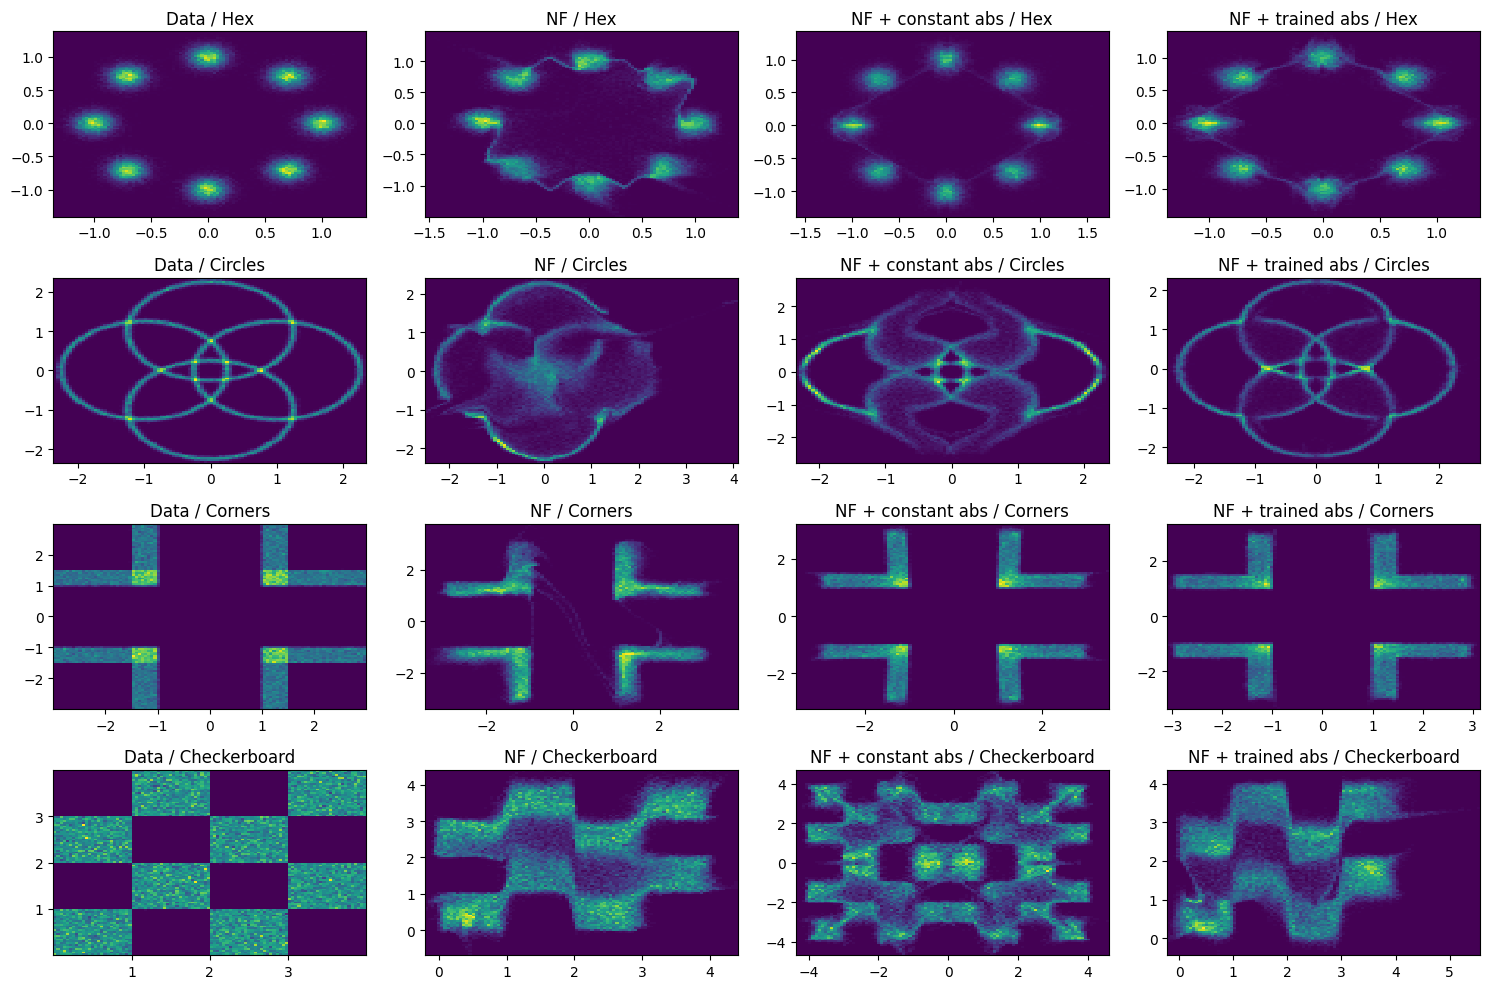

In [170]:
# Define dataset names
model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
dataset_names = ['Hex', 'Circles', 'Corners', 'Checkerboard']

sample_count = 100_000
bins = 100

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(sample_count).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=bins)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

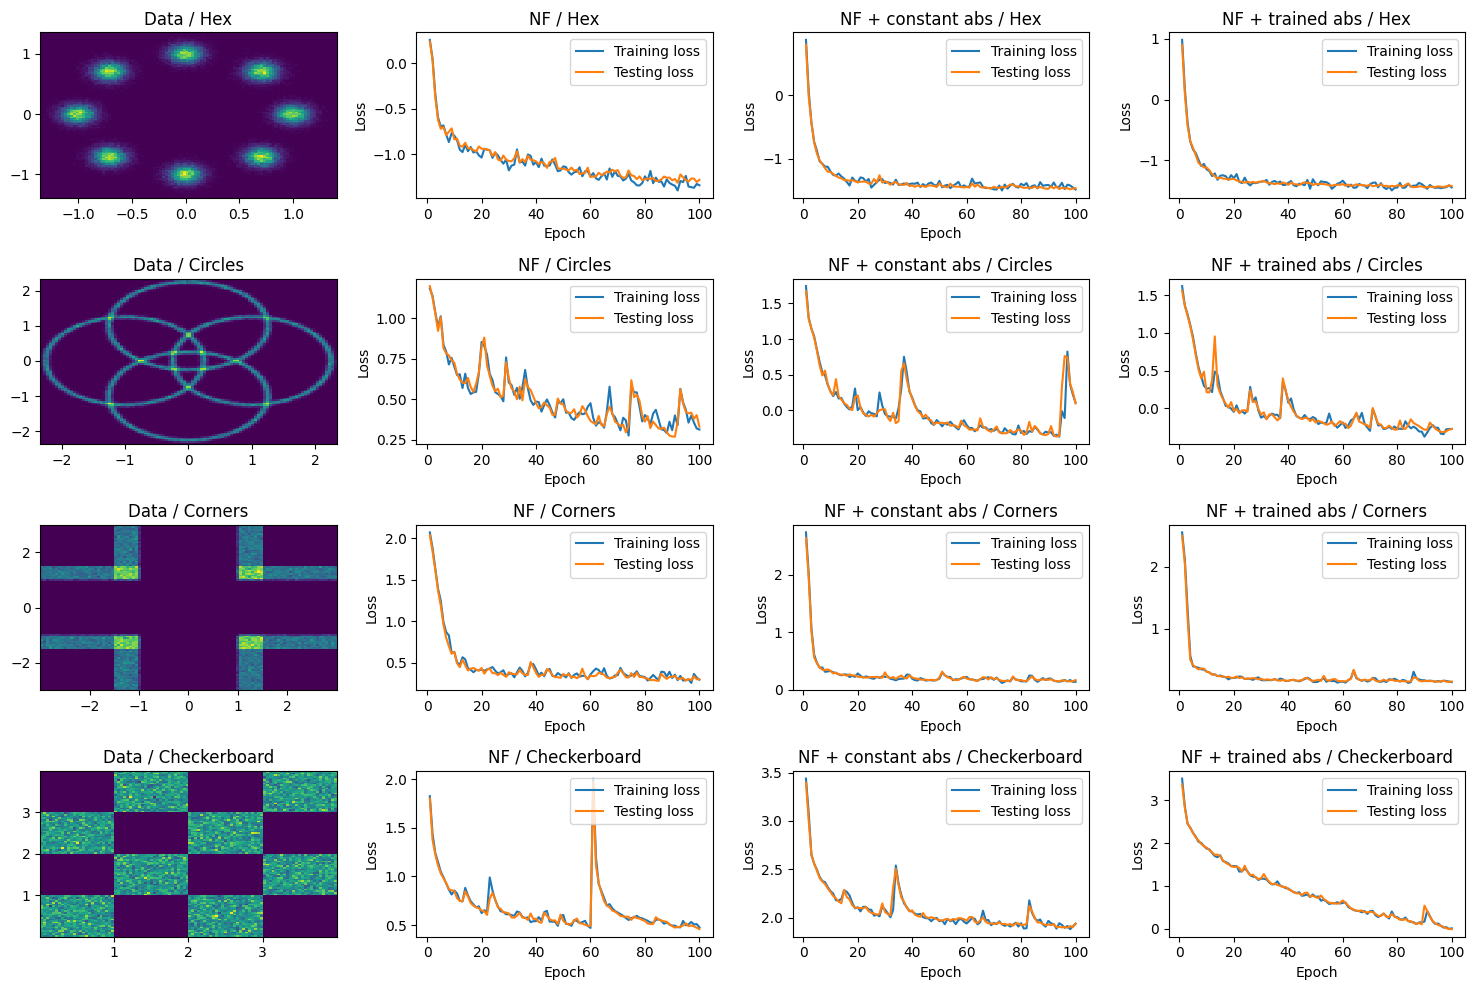

In [171]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epochs = range(1, len(training_loss) + 1)

        axs[i, j + 1].plot(epochs, training_loss, label='Training loss')
        axs[i, j + 1].plot(epochs, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

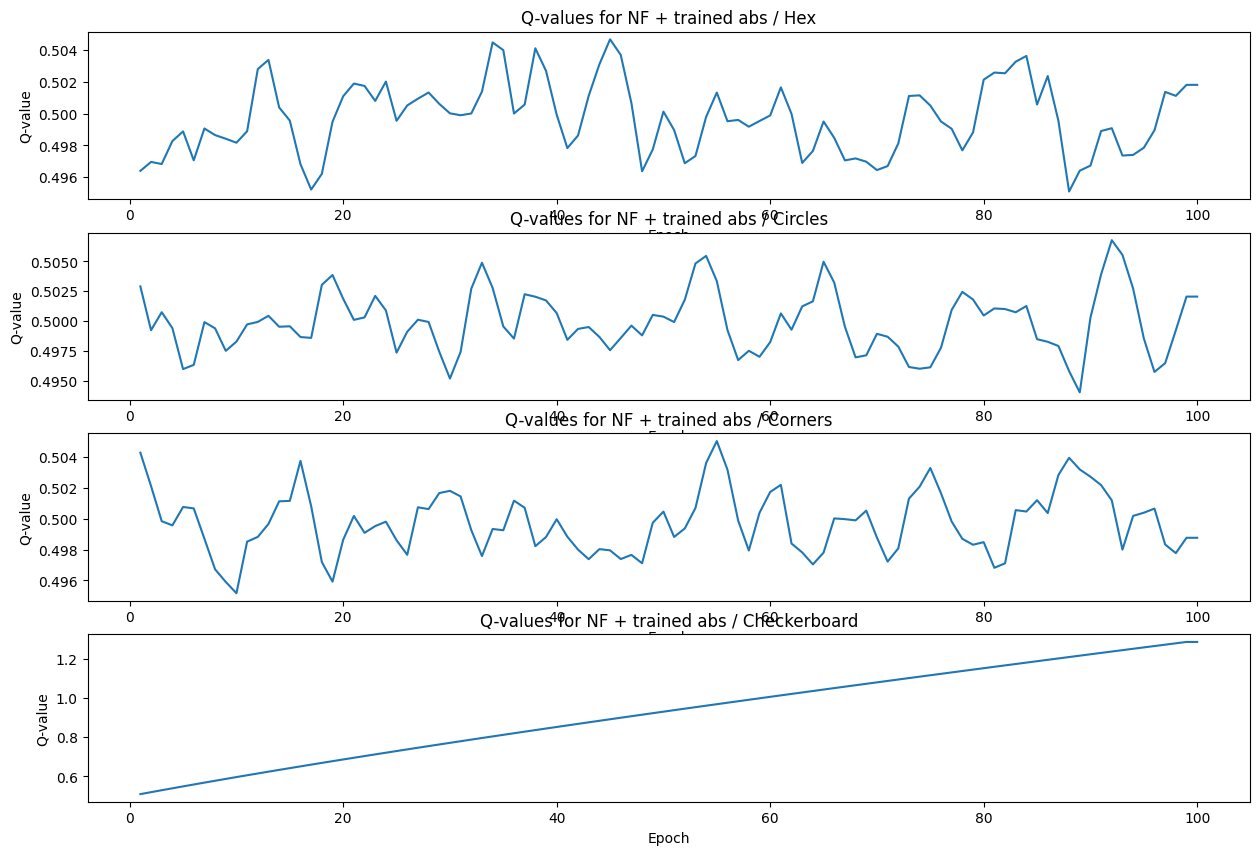

In [172]:
# TODO: go through the models and plot the values
fig, axs = plt.subplots(len(dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(model_names) - 1]
    
    qs = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        qs.append(model.layers[0].q.item())

    epochs = range(1, len(qs) + 1)
        
    axs[i].plot(epochs, qs)
    axs[i].set_title(f'Q-values for {model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')